# Electricity mixes of EU countries and the UK

This notebooks details the data preparation and plotting of chart showing electricity generation mixes of EU countries and the United Kingdom.

## Load prerequisities

This notebooks uses the Tidyverse libraries and the `ggtern` package. To install these libraries, run the command `install.packages(c("ggtern", "tidyverse"))` in your R instance.

In [100]:
library(tidyverse)
library(ggtern)

## Electricity generation data

For this visualization, we use the electricity generation data from the [Ember yearly electricity dataset](https://ember-climate.org/data-catalogue/yearly-electricity-data/). The Yearly Full Release Long Format” CSV file was downloaded into `/data/ember/yearly_full_release_long_format-1.csv`. The dataset is described as follows:

> The dataset contains yearly electricity generation, capacity, emissions, import and demand data for over 200 geographies. Data is collected from multi-country datasets (EIA, Eurostat, BP, UN) as well as national sources (e.g China data from the National Bureau of Statistics).

As we will need only annual electricity generation data for our analysis, and we will examine only the EU countries and the UK, we first need to filter the dataset accordingly.

In [101]:
DATASET_PATH <- "../data/ember/yearly_full_release_long_format-1.csv"

electricity_eu28 <- DATASET_PATH |>
  read_csv(# Select only columns relevant for our analysis.          
           col_select = c("Country code", "Year", "Category", "Variable", "Value", "Unit", "EU"),
           show_col_types = FALSE) |>
  # Filter EU countries and UK (= GBR), electricity generation category, and TWh unit.
  filter(EU == 1 | `Country code` == "GBR",
         Category %in% c("Electricity generation"),
         Unit == "TWh") |>
  select(CountryCode = "Country code",
         Year = "Year",
         SourceCategory = "Variable",
         ValueTWh = "Value") |>
  # Add a new column "ProdCategory" based on energy source.
  filter(SourceCategory %in% c("Fossil", "Nuclear", "Renewables"))

We now have the table of annual electricity generation per country and energy source category in a long format:

In [102]:
head(electricity_eu28)

CountryCode,Year,SourceCategory,ValueTWh
<chr>,<dbl>,<chr>,<dbl>
AUT,2000,Fossil,16.41
AUT,2000,Renewables,43.44
AUT,2000,Nuclear,0.00
AUT,2001,Fossil,18.82
AUT,2001,Renewables,42.24
AUT,2001,Nuclear,0.00


## Data wrangling

It will be convenient to also include EU-27 total electricity generation per year and per energy source category, therefore, we will add it into the data frame.

In [103]:
# Calculate EU-27 total electricity generation (= "ValueTWh") per "Year" and "ProdCategory".
electricity_eu27_total <- filter(electricity_eu28, CountryCode != "GBR") |>
  group_by(Year, SourceCategory) |>
  summarise(ValueTWh = sum(ValueTWh),
            .groups = "drop") |>
  mutate(CountryCode = "EU27",
         .before = Year)

head(electricity_eu27_total)

CountryCode,Year,SourceCategory,ValueTWh
<chr>,<dbl>,<chr>,<dbl>
EU27,2000,Fossil,1361.04
EU27,2000,Nuclear,859.95
EU27,2000,Renewables,406.95
EU27,2001,Fossil,1378.91
EU27,2001,Nuclear,888.90
EU27,2001,Renewables,436.35


In [104]:
# Append the total to the existing dataframe.
electricity_eu28 <- rbind(electricity_eu28, electricity_eu27_total)

Subsequently, we need to calculate share of yearly electricity generation by energy source (Fossil fuels, Nuclear, and Renewables) for each country (and the whole EU) so we can plot them in a [ternary plot](https://cran.r-project.org/web/packages/Ternary/vignettes/Ternary.html).

In [105]:
# Calculate electricity generation shares by energy source.
electricity_eu28_shares <- electricity_eu28 |>
  group_by(CountryCode, Year) |>
  transmute(SourceCategory = SourceCategory,
            Total = sum(ValueTWh),
            Share = ValueTWh / Total) |>
  ungroup() |>
  pivot_wider(names_from = SourceCategory, values_from = Share)

head(electricity_eu28_shares)

CountryCode,Year,Total,Fossil,Renewables,Nuclear
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AUT,2000,59.85,0.2741855,0.7258145,0
AUT,2001,61.06,0.3082214,0.6917786,0
AUT,2002,60.69,0.3096062,0.6903938,0
AUT,2003,58.06,0.3930417,0.6069583,0
AUT,2004,61.93,0.3602454,0.6397546,0
AUT,2005,64.49,0.3661033,0.6338967,0


## Generating a ternary plot

A ternary plot allows us to compare electricity mixes across various EU countries. It does so by placing each country within a triangle based on the share of each source (fossil fuels, nuclear, and renewables) on its electricity generation.

In [106]:
filter(electricity_eu28_shares, Year == 2021, CountryCode %in% c("ITA", "IRL", "EST", "GRC"))

CountryCode,Year,Total,Fossil,Renewables,Nuclear
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
EST,2021,7.19,0.6008345,0.3991655,0
GRC,2021,54.65,0.5950595,0.4049405,0
IRL,2021,31.60,0.6322785,0.3677215,0
ITA,2021,286.39,0.5938056,0.4061944,0


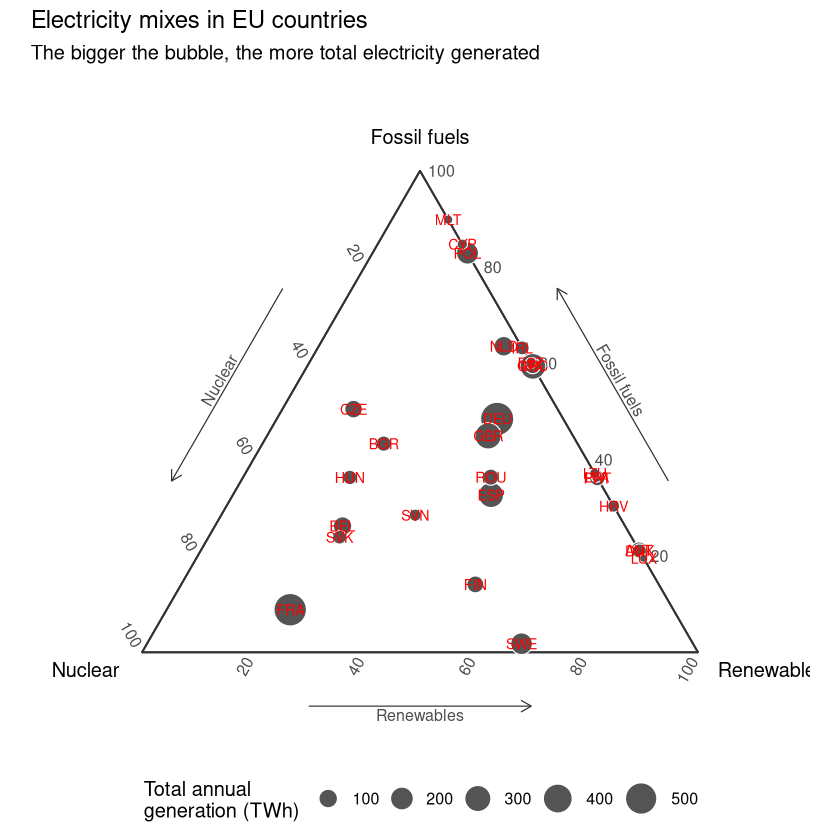

In [107]:
# Generate ternary plot as of 2021, leave out EU-27 as a whole.
ternary_plot_eu28_countries <- electricity_eu28_shares |>
  filter(Year == 2021, CountryCode != "EU27") |>
  arrange(-Total) |>
  ggtern(aes(Nuclear, Fossil, Renewables)) +
  geom_point(aes(size = Total), shape = 21, fill = "#545454", colour = "white") +
  geom_text(aes(label = CountryCode), size = 3, colour = "red") +
  scale_size("Total annual\ngeneration (TWh)", range = c(2, 9)) +
  labs(x = "Nuclear",
       y = "Fossil fuels",
       z = "Renewables",
       title = "Electricity mixes in EU countries",
       subtitle = "The bigger the bubble, the more total electricity generated") +
  theme_bw() +
  theme_nomask() +
  theme_showarrows() +
  theme(legend.position = "bottom")

ternary_plot_eu28_countries

If you wish to save the plot as an svg, you need to use "svglite" library, as "ggtern" does not work well with classic ggsave command.

In [108]:
# Save the plot as a standalone SVG file.
# svglite::svglite("ternary-plot-eu-countries.svg")
# ternary_plot_eu28_countries
# dev.off()

## Possible alterations of the plot

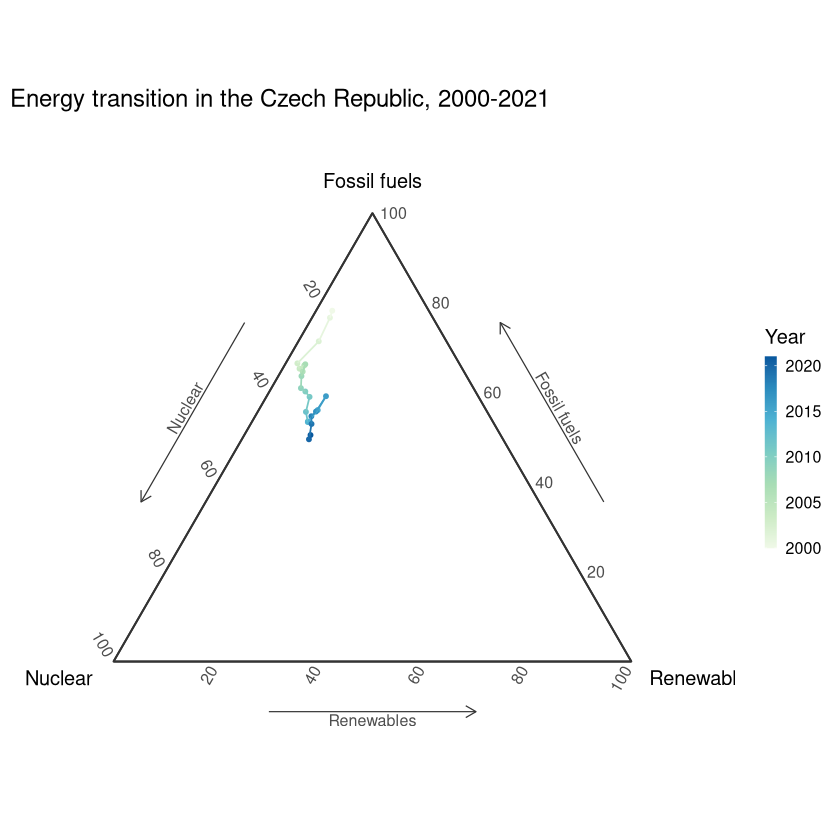

In [109]:
# Generate ternary plot showing energy transition of a single country.

ternary_plot_cze_path <- electricity_eu28_shares |>
  filter(CountryCode == "CZE") |>
  ggtern(aes(Nuclear, Fossil, Renewables)) +
  geom_point(aes(colour = Year), size = 1) +
  geom_path(aes(colour = Year)) +
  labs(x = "Nuclear",
       y = "Fossil fuels",
       z = "Renewables",
       title = "Energy transition in the Czech Republic, 2000-2021") +
  scale_colour_distiller("Year",
                         palette = "GnBu",
                         direction = 1,
                         guide = guide_colourbar(barheight = 8,
                                                 barwidth = 0.5,
                                                 title.position = "top")) +
  theme_nomask() +
  theme_bw() +
  theme_showarrows()

ternary_plot_cze_path